In [2]:
import numpy as np

from skimage import io, color, measure, draw, filters, feature, transform as tf, exposure, util

from skimage.filters import gaussian
from skimage.segmentation import flood, flood_fill

from sklearn.cluster import MiniBatchKMeans, KMeans

from matplotlib import path
import matplotlib.pyplot as plt

from scipy import ndimage, interpolate

import dill

In [33]:
### Phase 1: Preprocess & Choose palette 

rgb = io.imread("images/monet2.png")

# Params
C = 24
sigma = 1
factor = 5

blurred = gaussian(rgb[:,:,:3], sigma=sigma, multichannel=True)

In [34]:
def transform(rgb, C):
    lab = color.rgb2lab(rgb, illuminant='D65')
    lab_vec = np.reshape(lab, (np.floor(lab.size/3).astype(int), 3)) # Make it a vector of Lab coordinate points
#     kmeans = KMeans(n_clusters=C).fit(lab_vec)
    kmeans = MiniBatchKMeans(n_clusters=C).fit(lab_vec)
    prediction = kmeans.predict(lab_vec)
    prediction_lab_vec = kmeans.cluster_centers_[prediction] # Remap it back
    prediction_lab = np.reshape(prediction_lab_vec, lab.shape)
    prediction_rgb = color.lab2rgb(prediction_lab, illuminant='D65') # Image using C colors
    
    palette = color.lab2rgb(np.reshape(kmeans.cluster_centers_, (C, 1, 3)))
    return prediction_rgb, np.reshape(palette, (C, 3))

In [35]:
transformed_rgb, palette = transform(blurred, C)

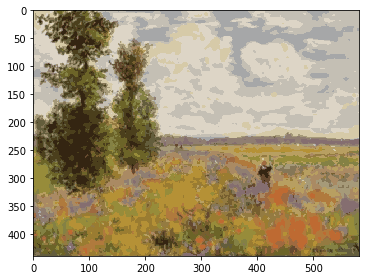

In [36]:
io.imshow(transformed_rgb) # with C colors

(24, 3)

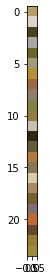

In [37]:
io.imshow(palette.reshape((C, 1, 3)))
palette.shape

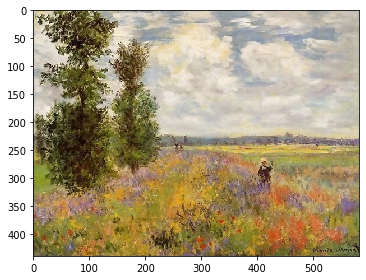

In [38]:
io.imshow(rgb) # original image

In [39]:
rescaled = tf.rescale(transformed_rgb, factor, multichannel=True, order=1)

In [40]:
def map_to_palette(img, palette):
    rows, cols, _ = img.shape
    new_img = np.zeros(img.shape)
    for r in range(rows):
        row = img[r] # (cols, 3)
        p = palette.reshape((C, 1, 3))
        d = np.linalg.norm(row-p, axis=2) # distances
        color_indices = np.argmin(d, axis=0)
        new_img[r] = palette[color_indices]

        if r % 1000 == 0: # to check progress
            print(r, rows)
    return new_img

In [41]:
phase1 = map_to_palette(rescaled, palette)

0 2195
1000 2195
2000 2195


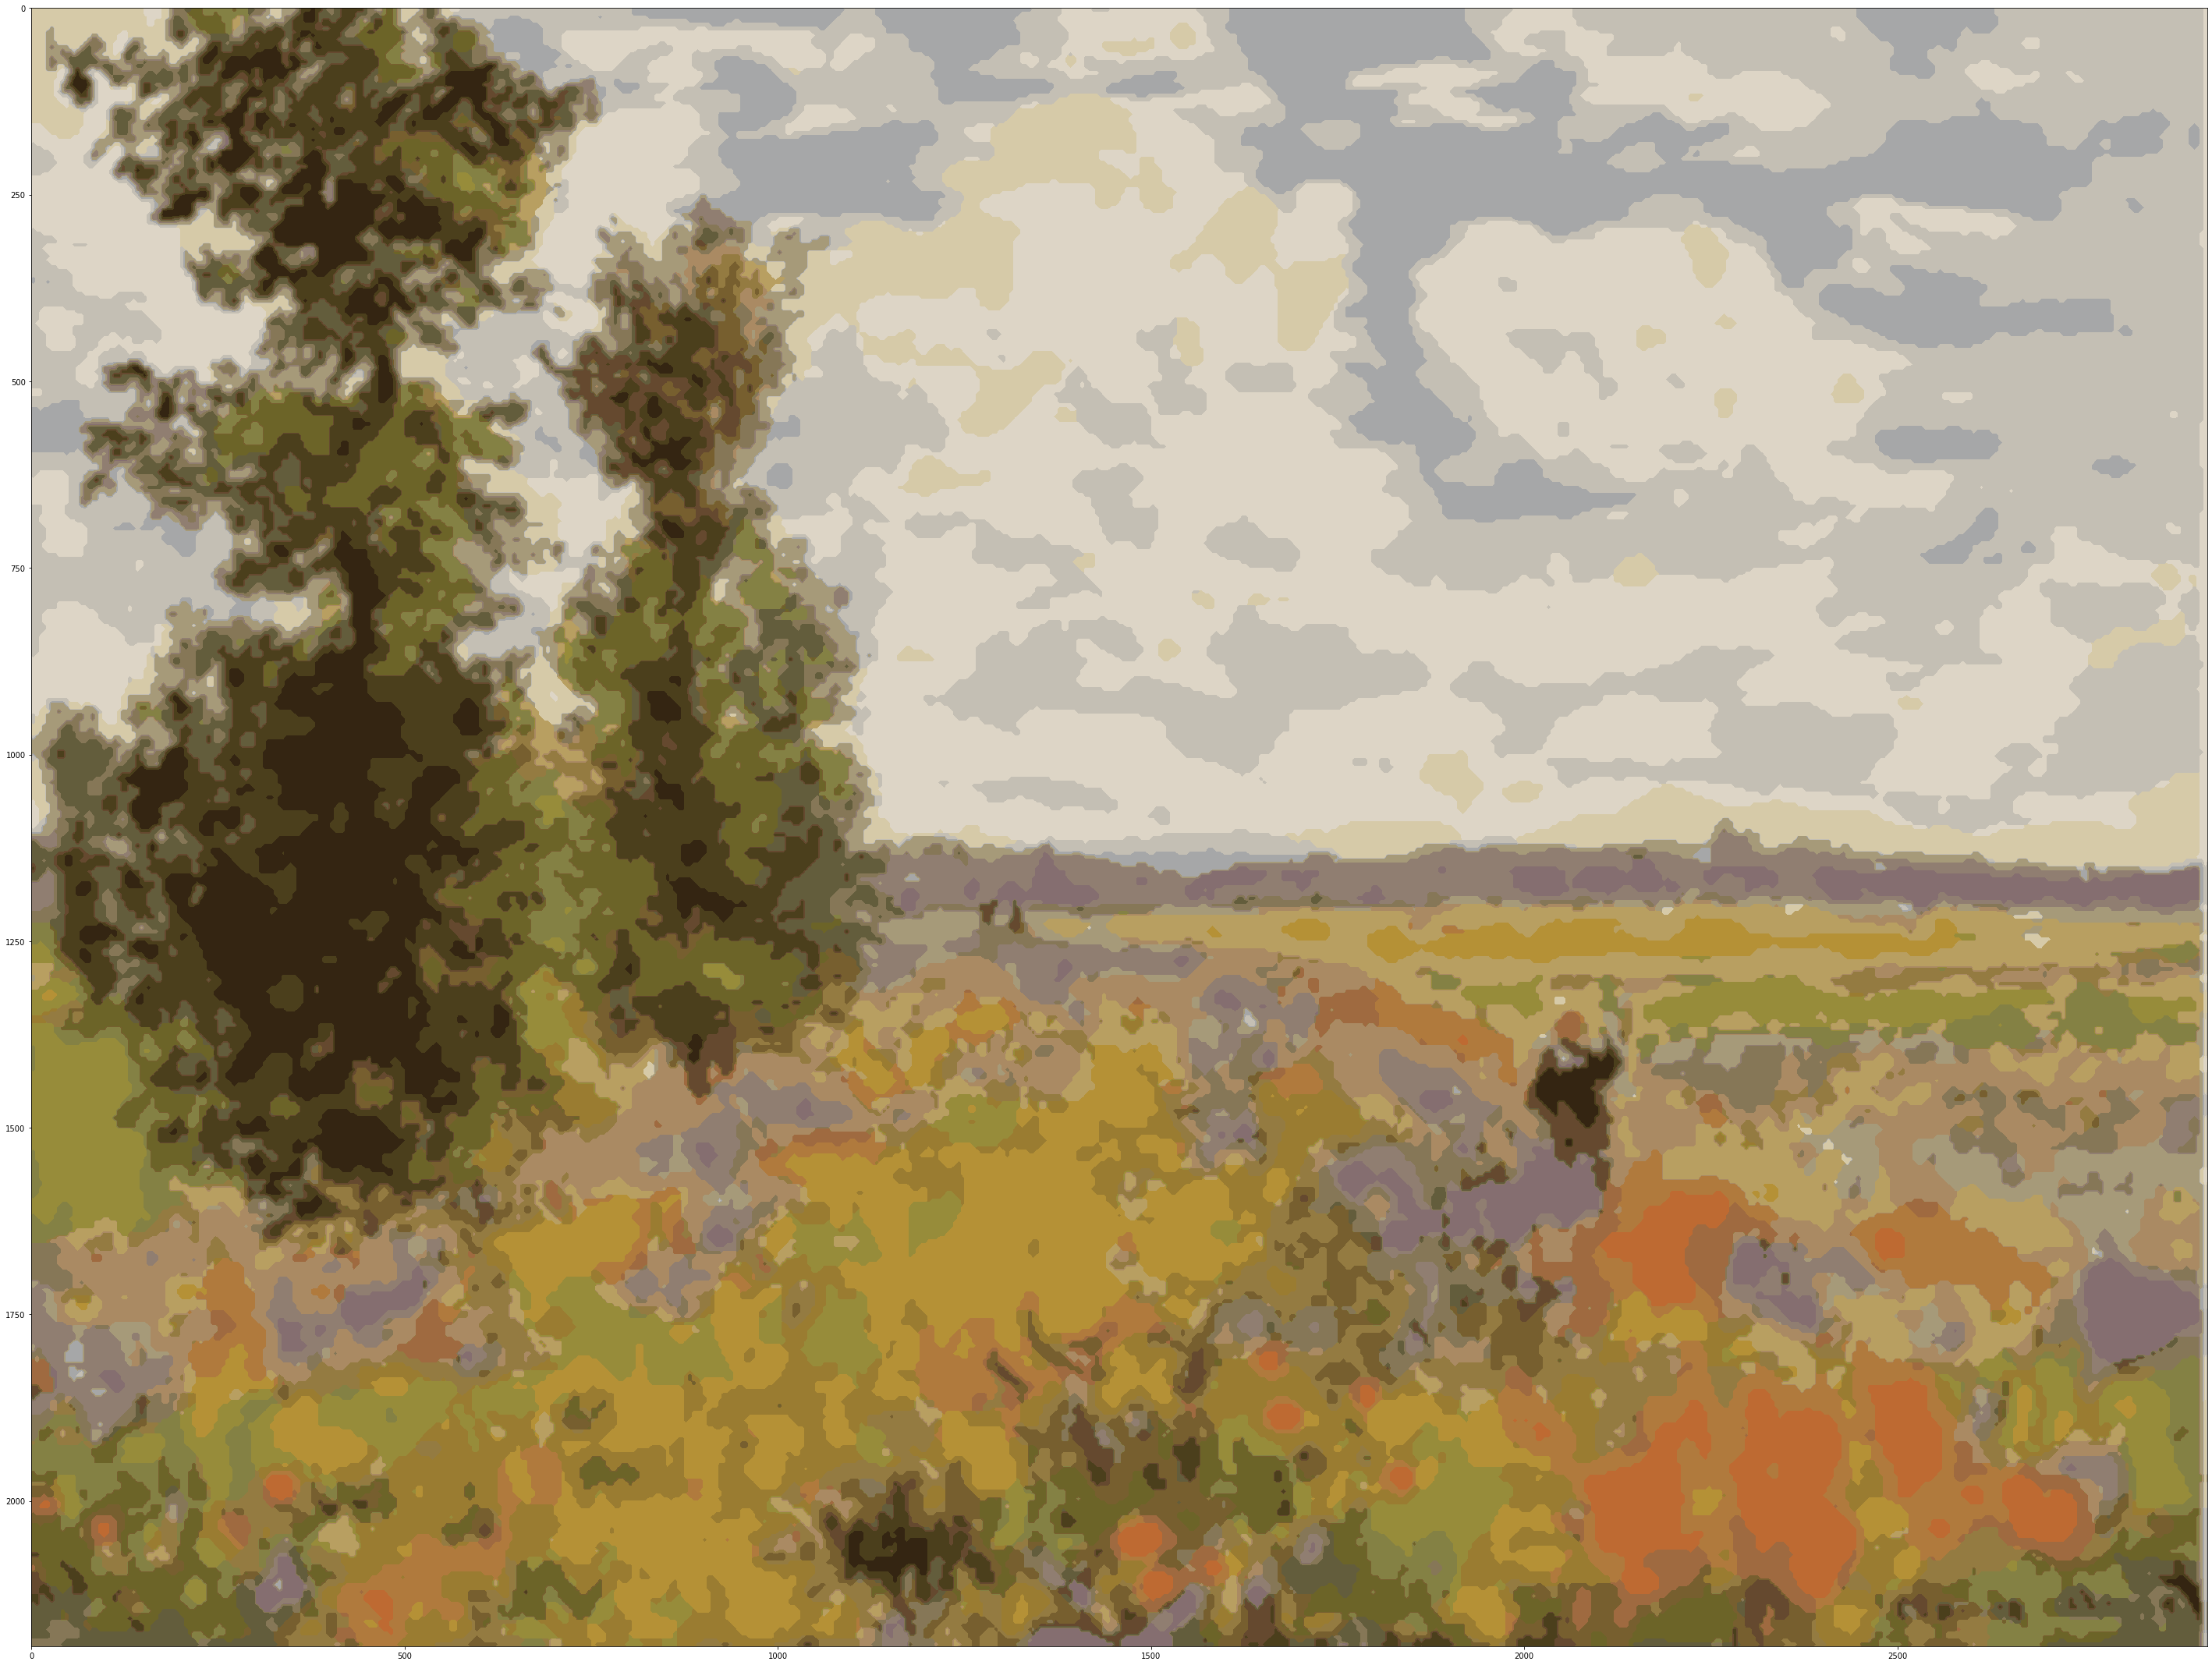

In [42]:
fig = plt.figure(figsize = (50,50))
plt.imshow(phase1)

In [43]:
### PHASE 2: Extract Contour

def extract_contour(img):
    rows, cols, _ = img.shape
    
    padded = np.pad(img, ((1, 1), (1, 1), (0,0)), 'edge')
    
    neighbors = util.view_as_windows(padded, (3, 3, 3)).reshape((rows, cols, 9, 3))

    contour = np.sum(np.sum(np.abs(neighbors - neighbors[:, :, 4, :].reshape((rows, cols, 1, 3))), axis=3), axis=2) > 0
    
    return contour

In [44]:
phase2 = extract_contour(phase1)

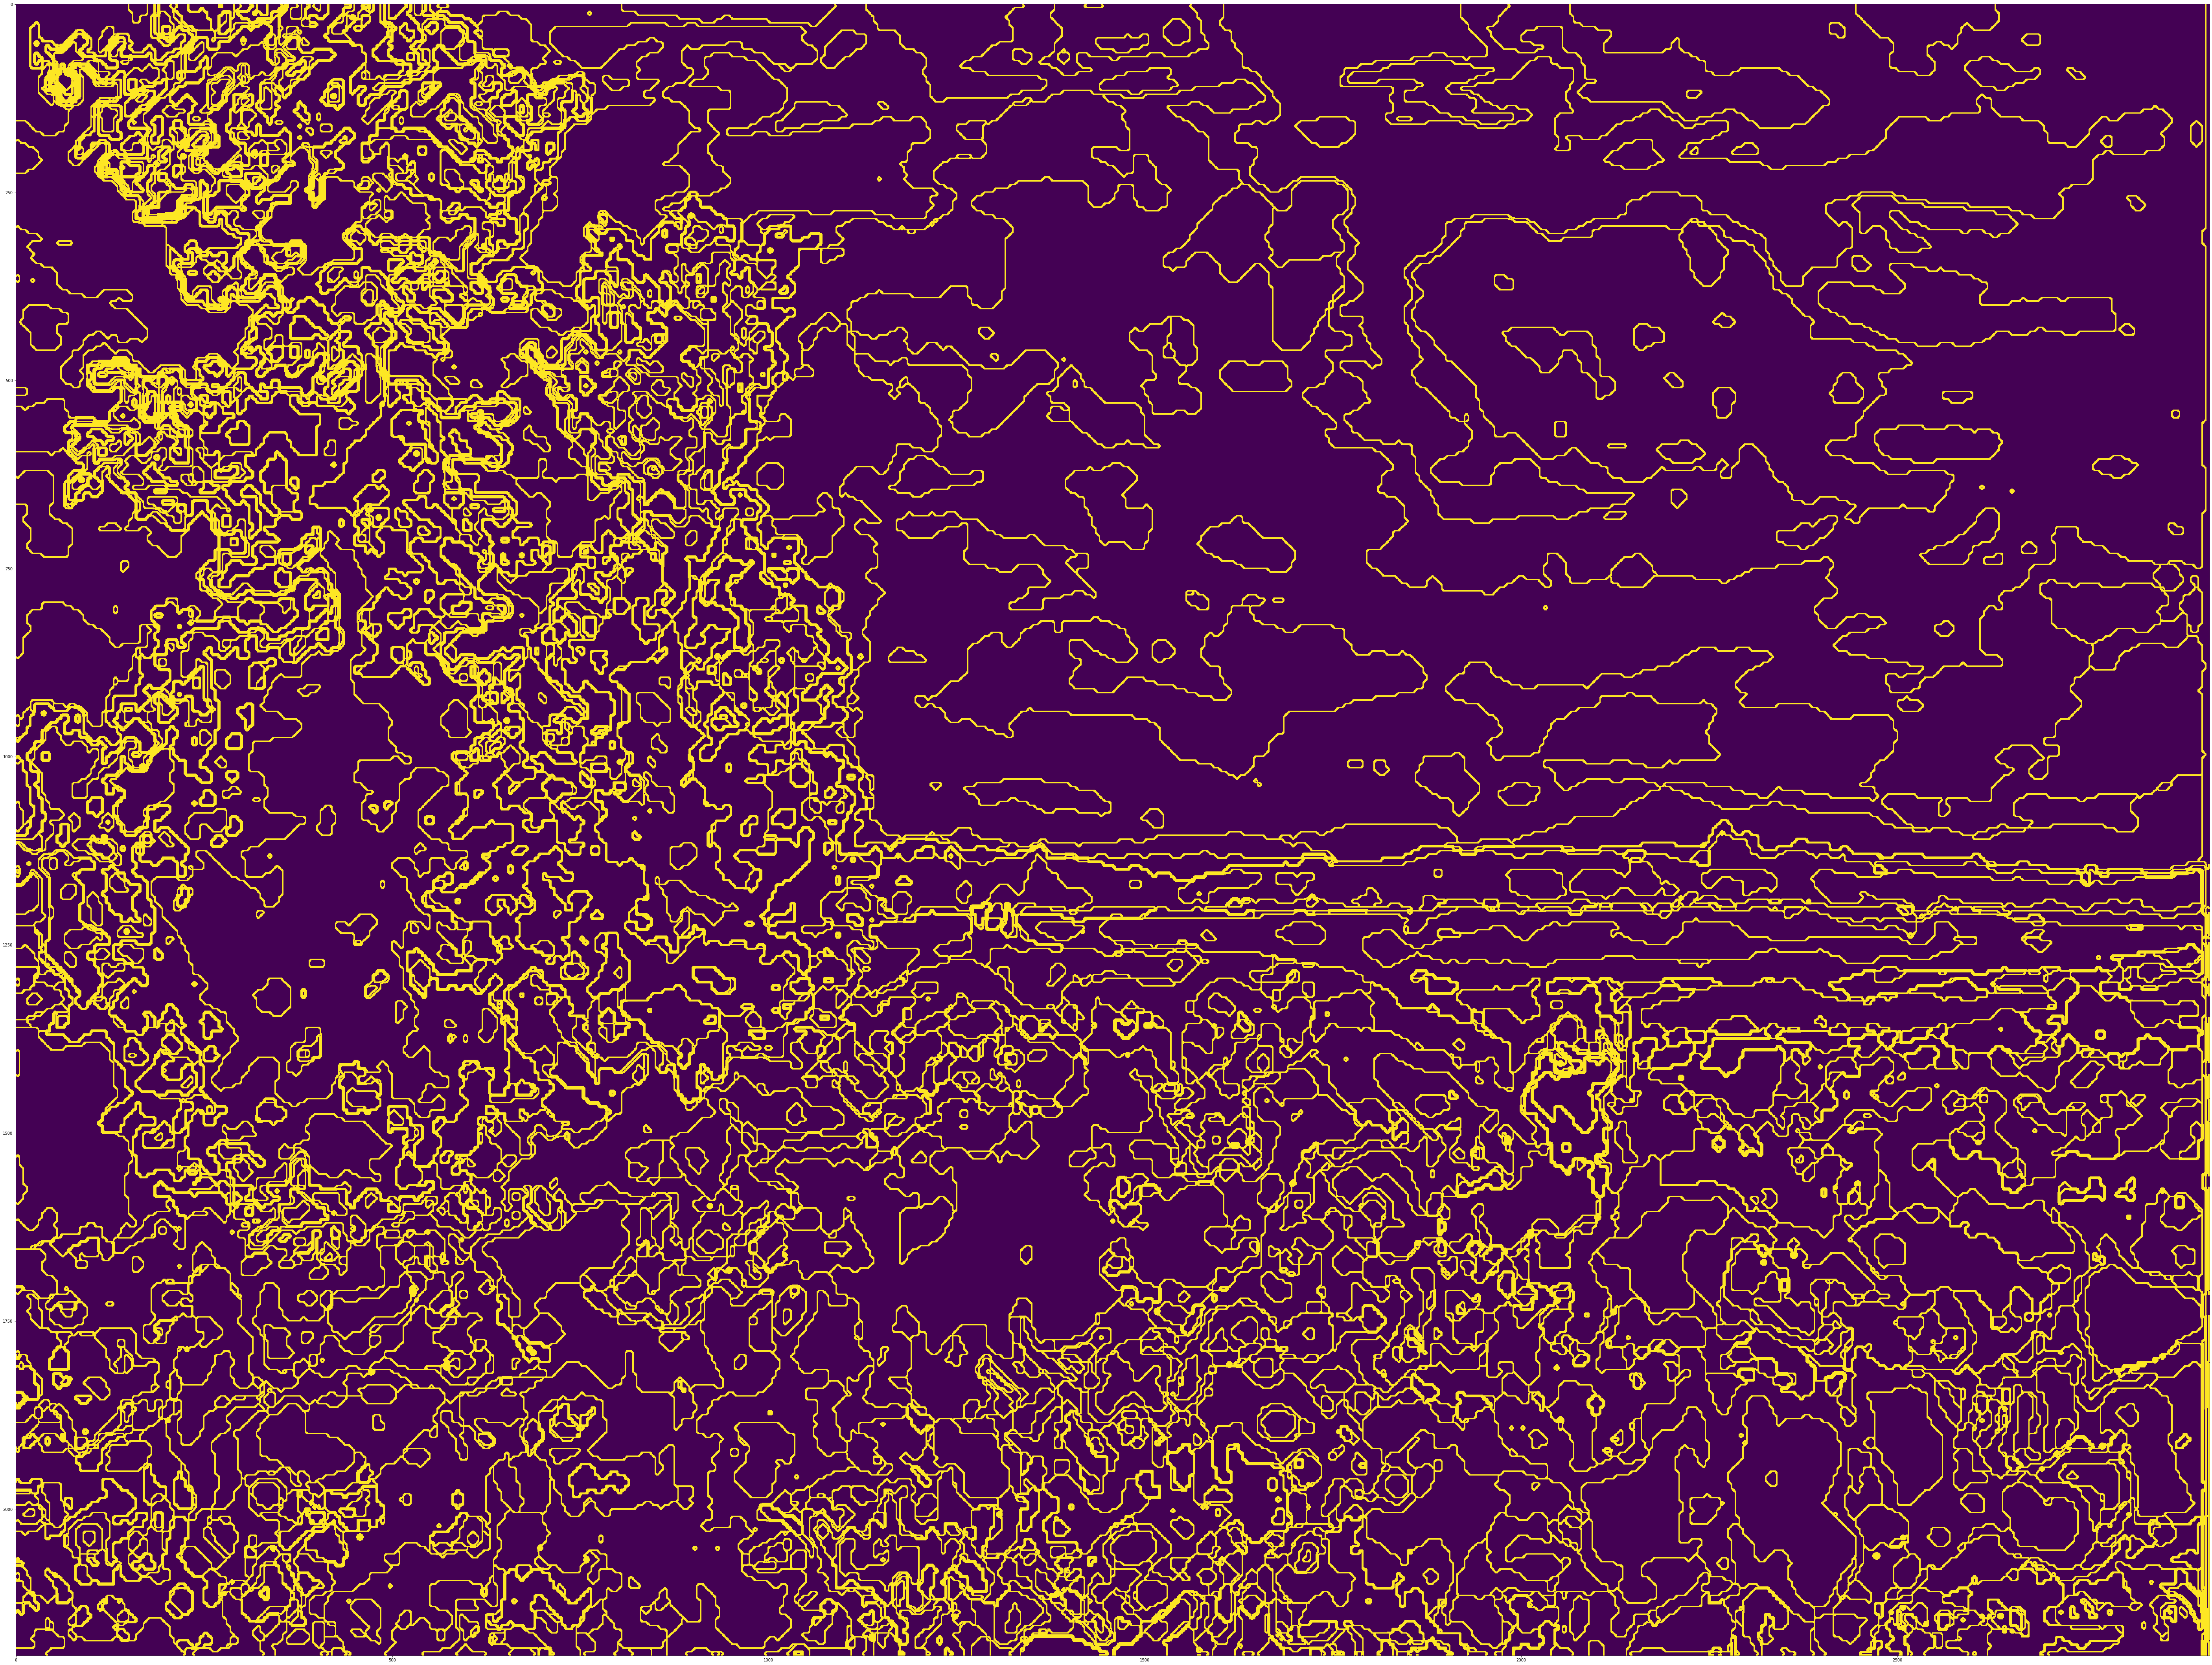

In [45]:
fig = plt.figure(figsize = (100,100))
plt.imshow(phase2)

In [46]:
### Phase 3 (For analysis): Reconstruction

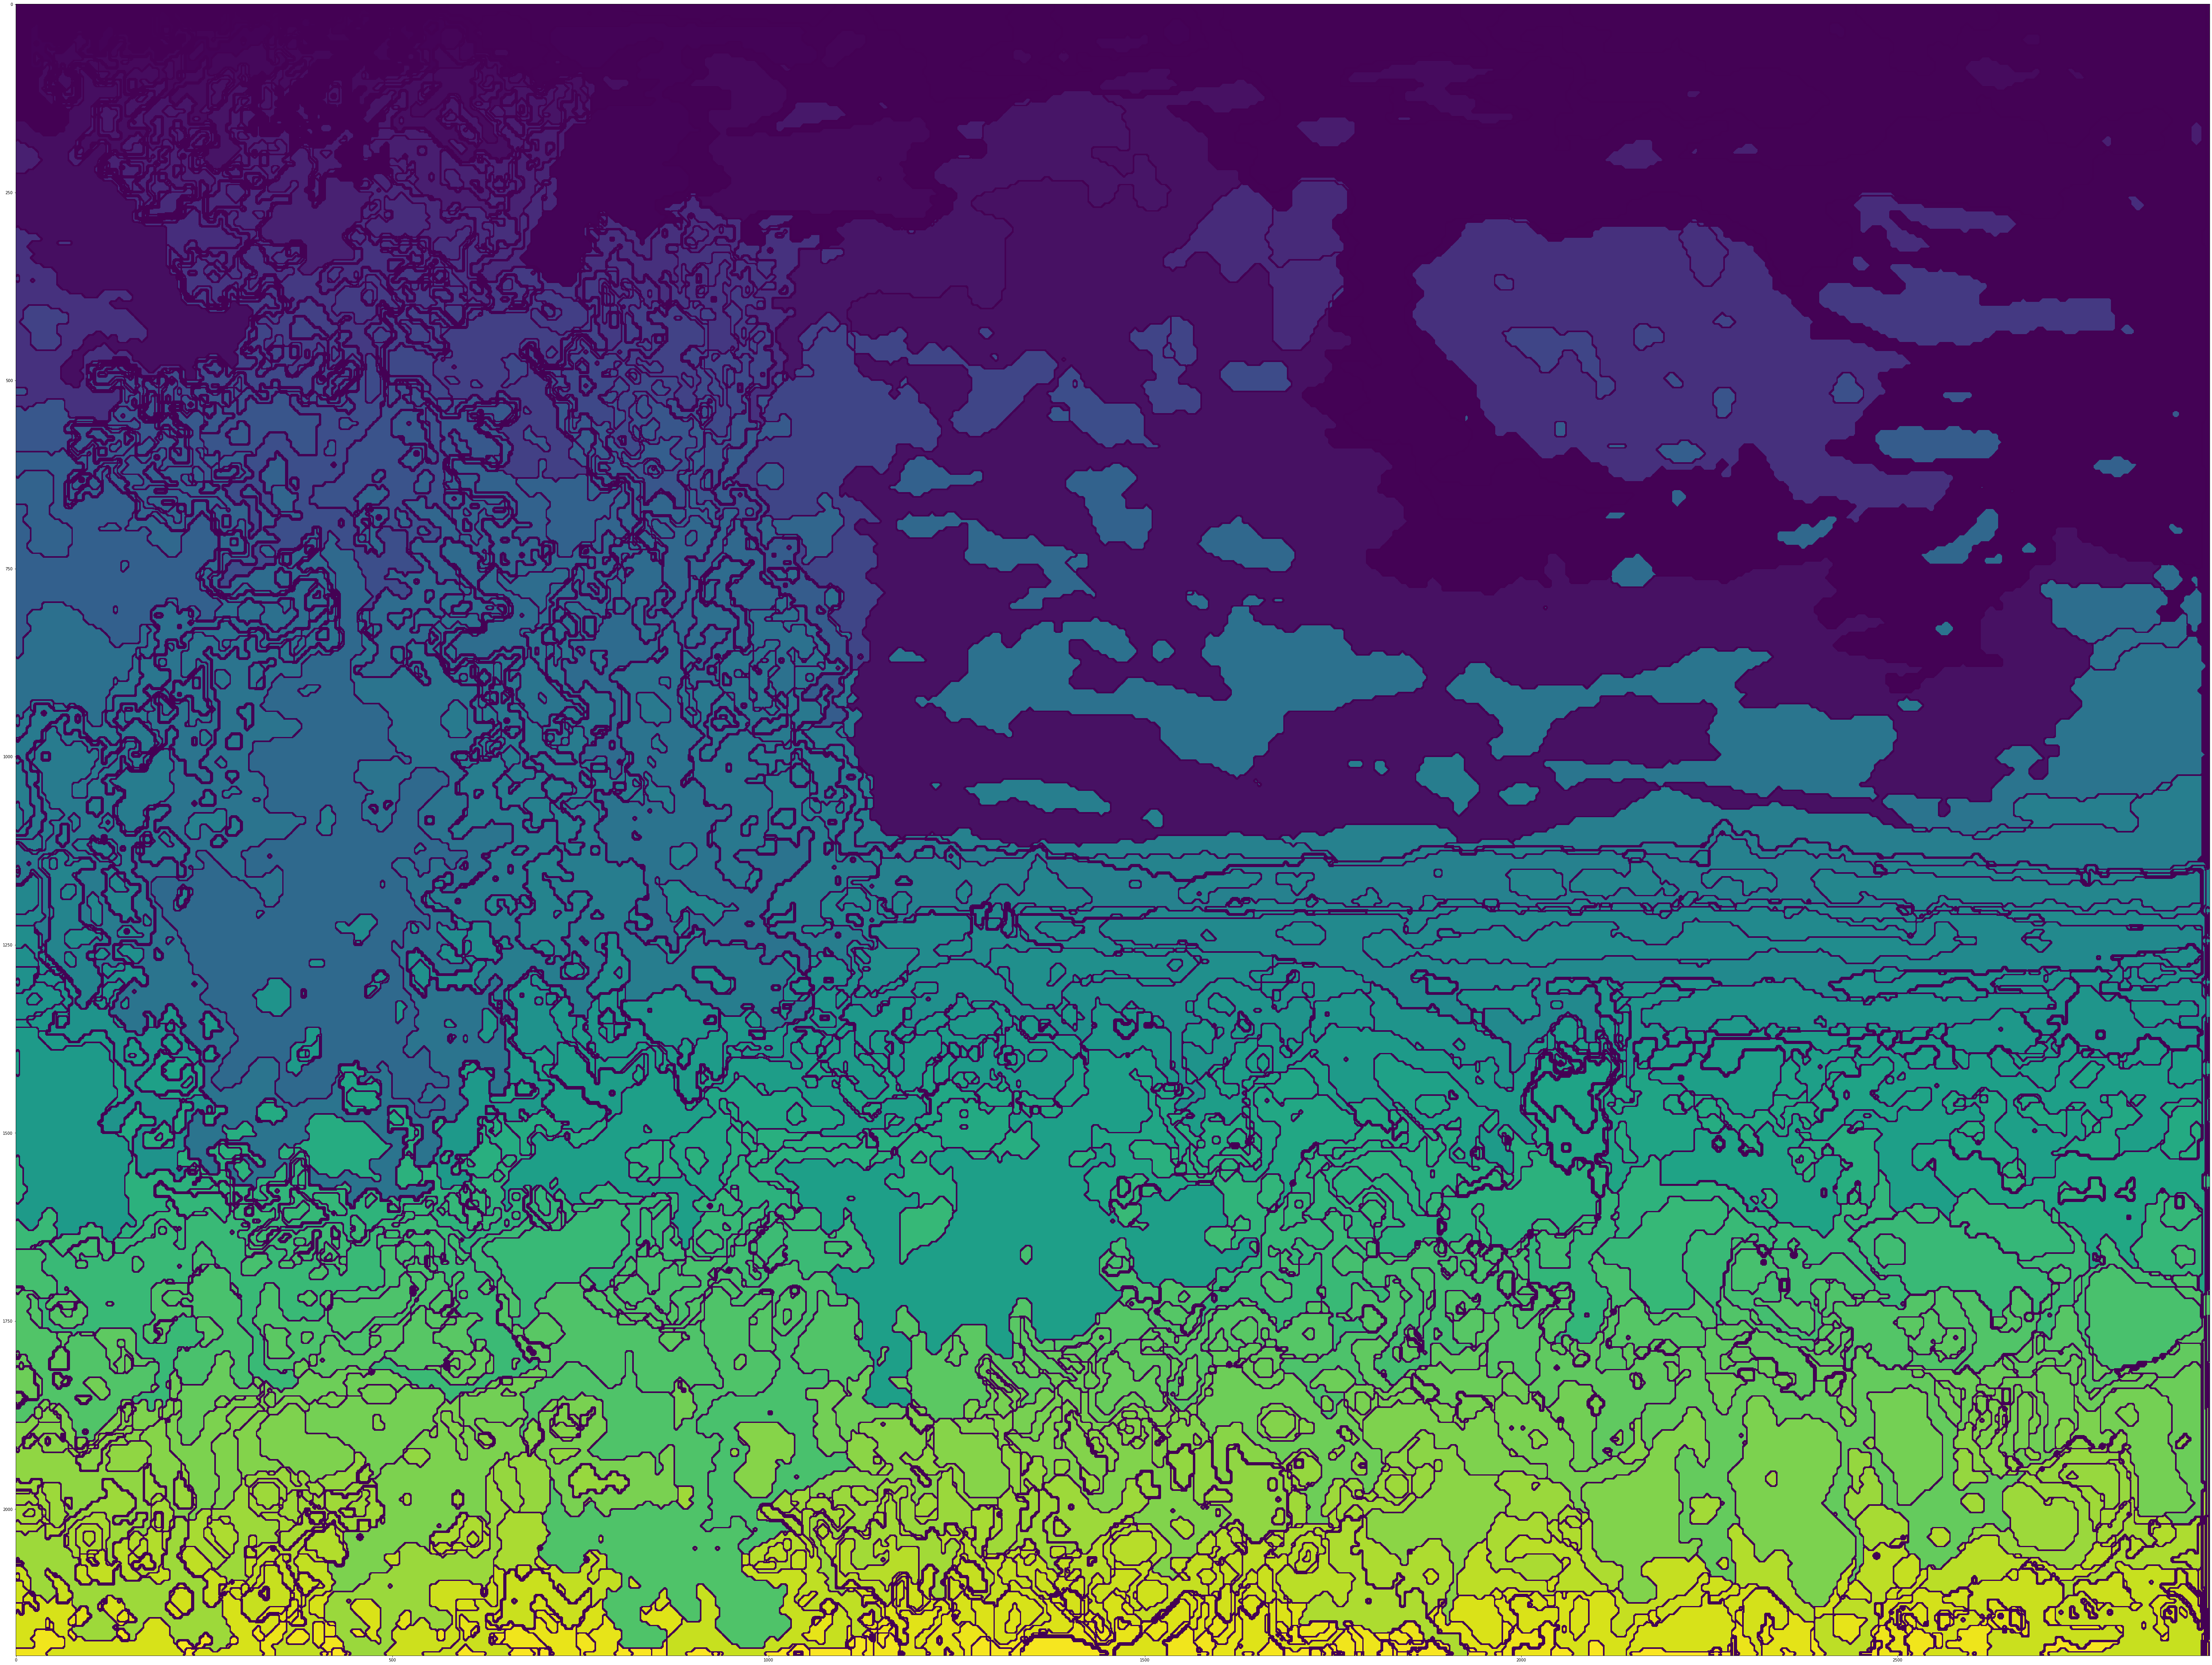

In [47]:
labeled = measure.label(phase2, connectivity=1, background=1)
fig = plt.figure(figsize = (100,100))
plt.imshow(labeled)

In [48]:
labels = np.arange(1,np.max(labeled)+1)
y, x = labeled.shape

sample_pts = {}
for r in range(y):
    for c in range(x):
        label = labeled[r][c]
        if label not in sample_pts:
            sample_pts[label] = np.array([r, c])
        
sample_pts = np.array([sample_pts[label] for label in labels])

In [49]:
sampled_colors = phase1[sample_pts[:,0], sample_pts[:,1]]
sampled_colors = np.insert(sampled_colors, 0, np.array([0, 0, 0]), axis=0)

In [50]:
final_img = sampled_colors[labeled]
final_img.shape

(2195, 2915, 3)

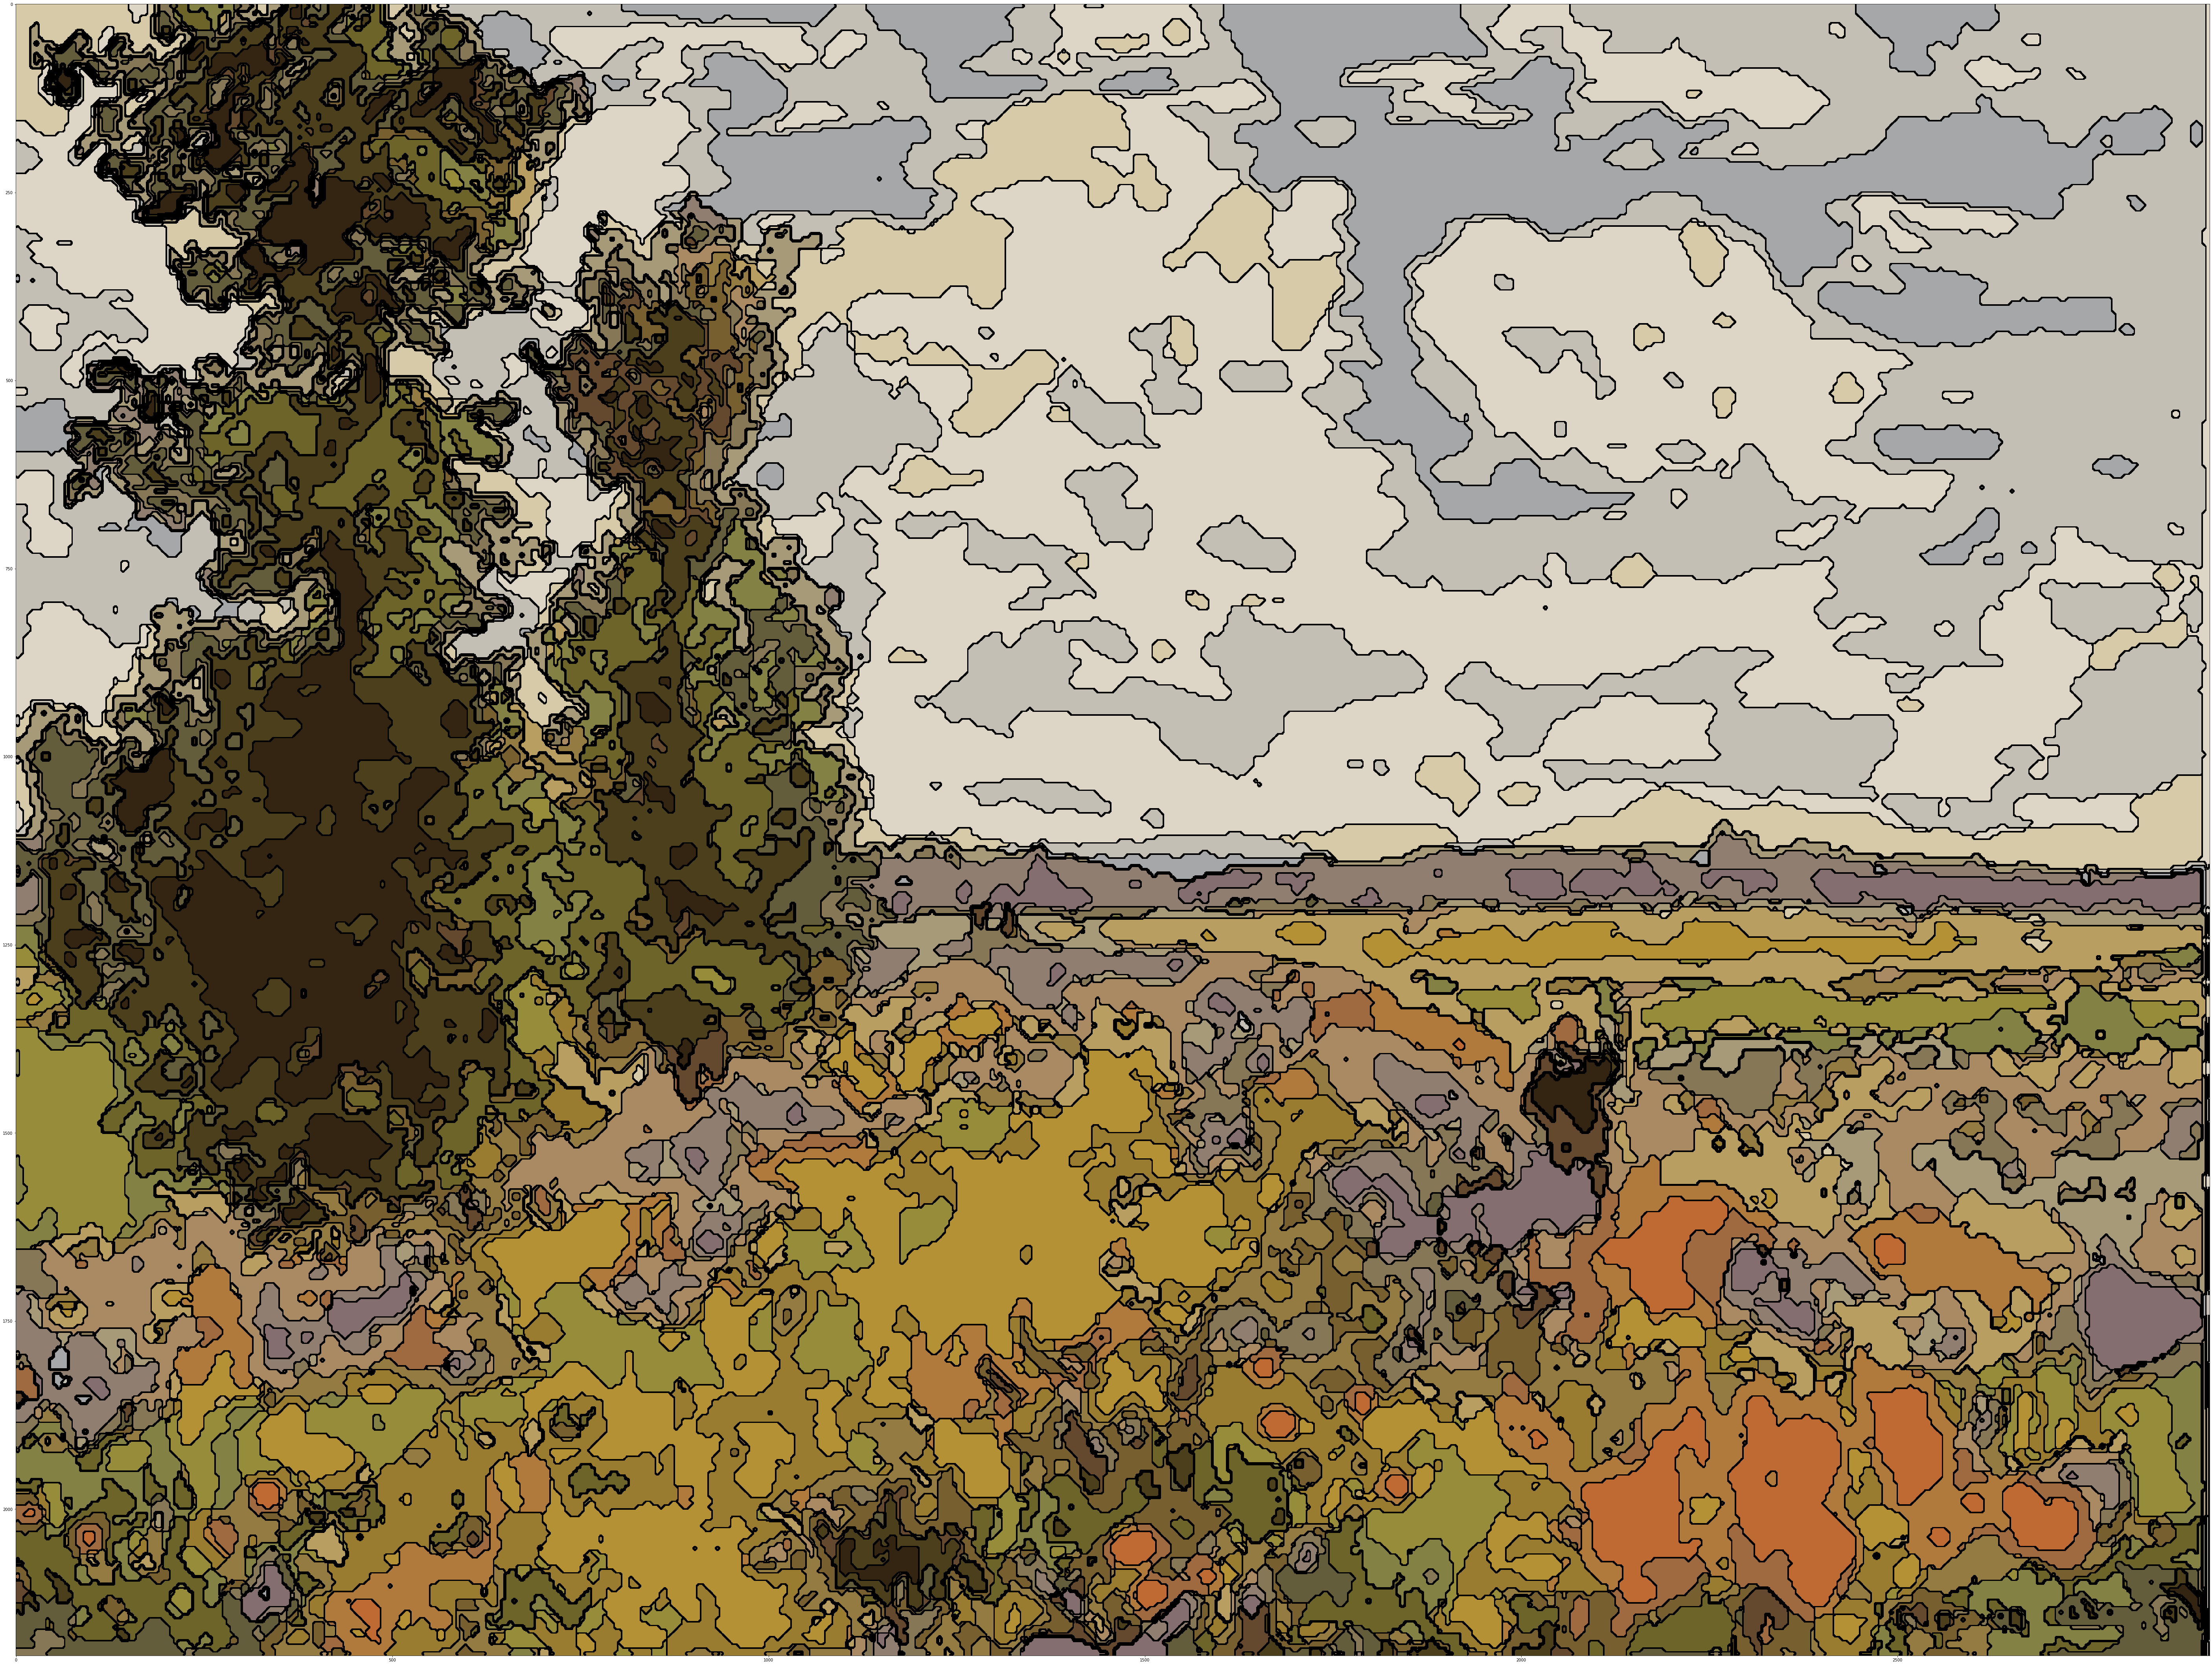

In [51]:
fig = plt.figure(figsize = (100,100))
plt.imshow(final_img)
# fig.savefig('colored.png', dpi=600)